# Выбор локации для скважины

Мне предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Необходимо также проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
def func_info(data):
    print('Описание датасета:')
    display(data.head(5))
    display(data.info())
    display(data.describe())
    display(data.corr())
    print(('Количество дубликатов по f0, f1, f2: {0}').format(data.drop(['id'], axis=1).duplicated().sum()))
    print(('Количество дубликатов по id: {0}').format(data['id'].duplicated().sum()))
    data = data.drop_duplicates(subset='id')
    print(('Количество дубликатов по id после удаления: {0}').format(data['id'].duplicated().sum()))
    print()
    data.hist(bins = 100, figsize=(10, 10));
    return 

In [4]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Описание датасета:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Количество дубликатов по f0, f1, f2: 0
Количество дубликатов по id: 10
Количество дубликатов по id после удаления: 0

Описание датасета:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Количество дубликатов по f0, f1, f2: 0
Количество дубликатов по id: 4
Количество дубликатов по id после удаления: 0

Описание датасета:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Количество дубликатов по f0, f1, f2: 0
Количество дубликатов по id: 4
Количество дубликатов по id после удаления: 0



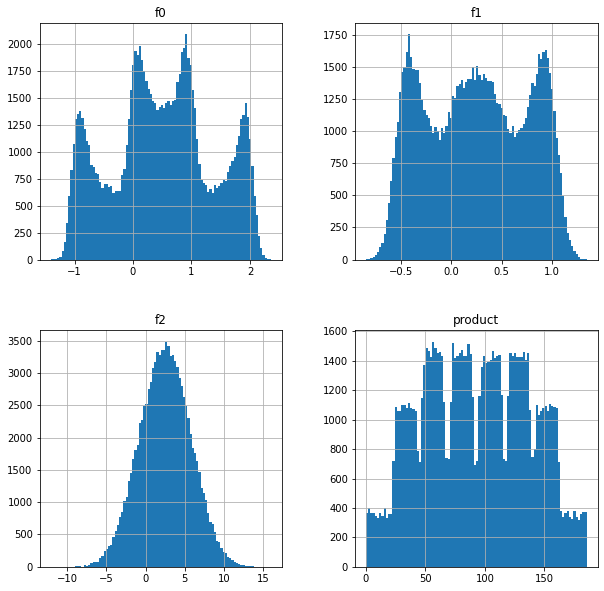

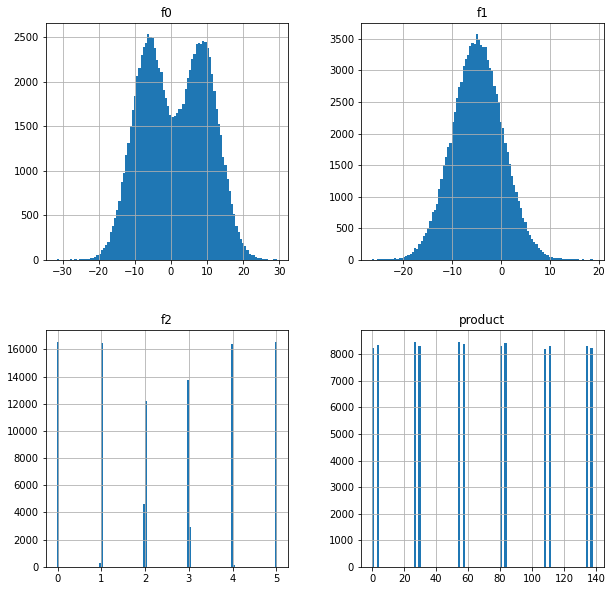

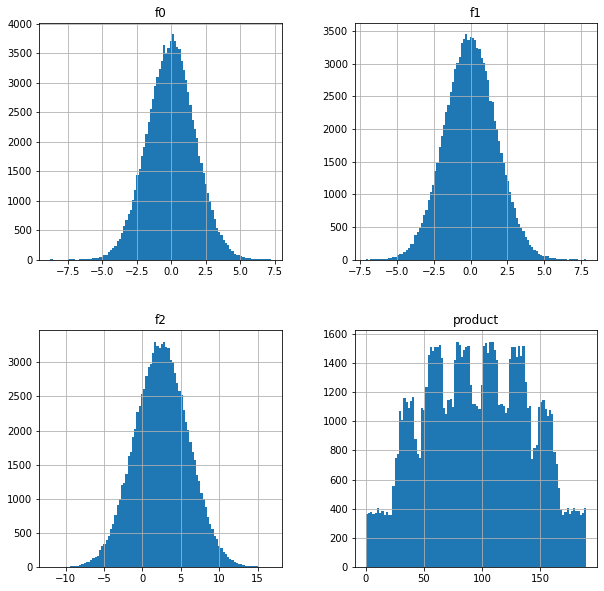

In [5]:
for data in [data_0, data_1, data_2]:
    func_info(data)

Вывод:

Данные были выгружены и проанализированы: в данных отсутствуют пропущенные значения и аномалии, типы данных соответсвуют нужным, дубликаты были удалены. Распределения целевых признаков для трех датасетов сильно отличаются: данные второго датасета распределены неравномерно и разделяются на 12 явно выраженных групп, а первый и третий дататсет распределены более равномерно.

## Обучение и проверка модели

In [6]:
pd.options.mode.chained_assignment = None

In [7]:
def func_predict(data, numeric = ['f0', 'f1', 'f2']):
    features = data.drop(['id', 'product'], axis = 1) 
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, 
        target, 
        test_size=0.25, 
        random_state=12345)
    scaler = StandardScaler()
    scaler.fit(features_train[numeric]) 
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    model = LinearRegression()
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid) 
    mean = predictions_valid.mean()
    rmse = mean_squared_error(target_valid, predictions_valid, squared=False)
    r2 = r2_score(target_valid, predictions_valid)
    mae = mean_absolute_error(target_valid, predictions_valid)
    print(('Cредний запас предсказанного сырья = {0}').format(round(mean,2)))
    print(('RMSE = {0}').format(round(rmse,2)))
    print(('MAE = {0}').format(round(mae,2)))
    print(('R2 = {0}').format(round(r2,2)))
    return target_valid, predictions_valid, mean, rmse, r2, mae    

In [8]:
target_0, predictions_0, mean_0, rmse_0, r2_0, mae_0 = func_predict(data_0)    

Cредний запас предсказанного сырья = 92.59
RMSE = 37.58
MAE = 30.92
R2 = 0.28


In [9]:
target_1, predictions_1, mean_1, rmse_1, r2_1, mae_1 = func_predict(data_1)   

Cредний запас предсказанного сырья = 68.73
RMSE = 0.89
MAE = 0.72
R2 = 1.0


In [10]:
target_2, predictions_2, mean_2, rmse_2, r2_2, mae_2 = func_predict(data_2)    

Cредний запас предсказанного сырья = 94.97
RMSE = 40.03
MAE = 32.79
R2 = 0.21


Вывод:

Средний запас предсказанного сырья выше всего у первого датасета и третьего датасета. Метрика RMSE меньше всего у второго датасета. Модель для второго датасета предсказывает значения лучше чем остальные. Это связано с неравномерным распределнением датасета (с выраженными группами значений), также корреляция столбцов f2 и product для второго датасета очень высокая. 

## Подготовка к расчёту прибыли

In [11]:
Points_sum_ML_before = 500
Points_sum_ML_after = 200
Budget = 10000000000
Revenue = 450000
one_point_budget = Budget / Points_sum_ML_after
product_min = one_point_budget / Revenue
('Объём сырья для безубыточной разработки новой скважины = {0}').format(round(product_min,2))

'Объём сырья для безубыточной разработки новой скважины = 111.11'

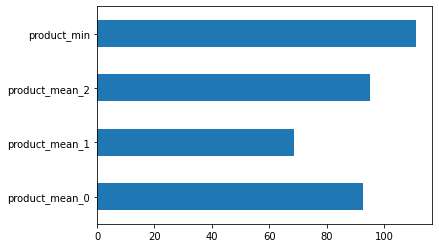

In [12]:
s_mean = pd.Series(data=[mean_0, mean_1, mean_2, product_min], 
                    index=['product_mean_0', 'product_mean_1', 'product_mean_2', 'product_min'])
s_mean.plot(kind='barh');

In [13]:
def revenue_all(target, predictions, count, revenue, budget):
    pred_sorted = predictions.sort_values(ascending=False)
    selected = target[pred_sorted.index][:count]
    return revenue * selected.sum() - budget

Вывод:

Объём сырья для безубыточной разработки новой скважины по данному условию равняется 111 тыс. бареллей. Данное значение превышает средние значения всех датасетов. Если мы выберем 200 скважин случайно, то есть риск не получить прибыли. Требуется при помощи машинного обучения отобрать 200 самых перспективных скважин.

## Расчёт прибыли и рисков 

In [14]:
def func_bootstrap(target, predictions, points_sum_ML_before, points_sum_ML_after, revenue, budget):
    state = np.random.RandomState(12345)
    values = []
    predictions = pd.Series(predictions, index=target.index)
    for i in range(1000):        
        target_subsample = target.sample(n=points_sum_ML_before, replace=True, random_state=state)
        pred_subsample = predictions[target_subsample.index]     
        values.append(revenue_all(target_subsample, pred_subsample, points_sum_ML_after, revenue, budget))
    values = pd.Series(values)
    values_mean = values.mean()
    lower_quantile = values.quantile(0.025)
    upper_quantile = values.quantile(0.975)
    values_loss = (values < 0).mean()
    print(('Средняя прибыль = {0} млн. руб.').format(round(values_mean/1000000,2)))
    print(('95%-й доверительный интервал = {0} - {1} млн. руб.').format(
                                                                round(lower_quantile/1000000,2), 
                                                                round(upper_quantile/1000000,2)))
    print(('Риск убытков = {0}').format(values_loss*100))
    values.hist(bins=50);
    plt.axvline(x=values_mean);
    plt.axvline(x=lower_quantile);
    plt.axvline(x=upper_quantile);
    return values, values_mean, lower_quantile, upper_quantile

Средняя прибыль = 425.94 млн. руб.
95%-й доверительный интервал = -102.09 - 947.98 млн. руб.
Риск убытков = 6.0


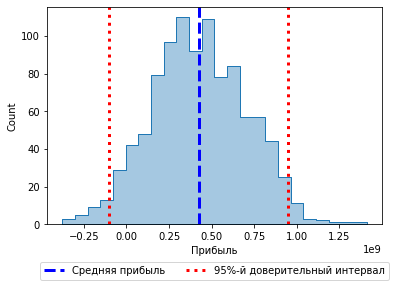

In [15]:
# def func_bootstrap_2(target, predictions, points_sum_ML_before, points_sum_ML_after, revenue, budget):
#     state = np.random.RandomState(12345)
#     values = []
#     predictions = pd.Series(predictions, index=target.index)
#     for i in range(1000):        
#         target_subsample = target.sample(n=points_sum_ML_before, replace=True, random_state=state)
#         pred_subsample = predictions[target_subsample.index]     
#         values.append(revenue_all(target_subsample, pred_subsample, points_sum_ML_after, revenue, budget))
#     values = pd.Series(values)
#     values_mean = values.mean()
#     lower_quantile = values.quantile(0.025)
#     upper_quantile = values.quantile(0.975)
#     values_loss = (values < 0).mean()
#     print(('Средняя прибыль = {0} млн. руб.').format(round(values_mean/1000000,2)))
#     print(('95%-й доверительный интервал = {0} - {1} млн. руб.').format(
#                                                                 round(lower_quantile/1000000,2), 
#                                                                 round(upper_quantile/1000000,2)))
#     print(('Риск убытков = {0}').format(values_loss*100))
    
#     sns.histplot(values, alpha=0.4,  element="step")
#     plt.xlabel('Прибыль')
#     plt.axvline(x=values_mean, color='b', ls='--', lw=3, label='Средняя прибыль')
#     plt.axvline(x=lower_quantile, color='r', ls=':', lw=3, label='95%-й доверительный интервал')
#     plt.axvline(x=upper_quantile, color='r', ls=':', lw=3)
#     plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
#     plt.show()
    
# func_bootstrap_2(target_0, predictions_0, Points_sum_ML_before, Points_sum_ML_after, Revenue, Budget)

Средняя прибыль = 425.94 млн. руб.
95%-й доверительный интервал = -102.09 - 947.98 млн. руб.
Риск убытков = 6.0


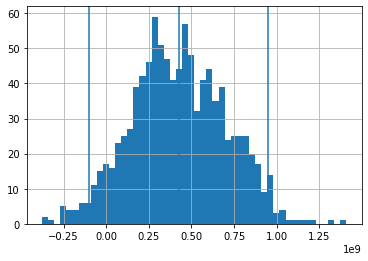

In [16]:
values_0, values_mean_0, lower_quantile_0, upper_quantile_0 = func_bootstrap(target_0, 
                                                                           predictions_0, 
                                                                           Points_sum_ML_before, 
                                                                           Points_sum_ML_after, 
                                                                           Revenue, 
                                                                           Budget)

Средняя прибыль = 515.22 млн. руб.
95%-й доверительный интервал = 68.87 - 931.55 млн. руб.
Риск убытков = 1.0


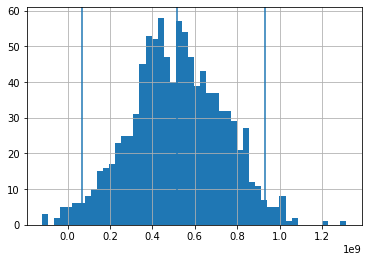

In [17]:
values_1, values_mean_1, lower_quantile_1, upper_quantile_1 = func_bootstrap(target_1, 
                                                                           predictions_1, 
                                                                           Points_sum_ML_before, 
                                                                           Points_sum_ML_after, 
                                                                           Revenue, 
                                                                           Budget)

Средняя прибыль = 435.01 млн. руб.
95%-й доверительный интервал = -128.88 - 969.71 млн. руб.
Риск убытков = 6.4


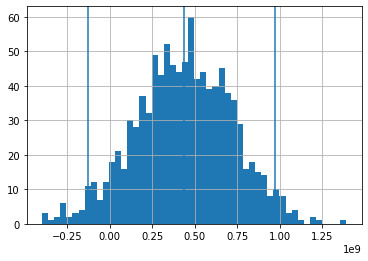

In [18]:
values_2, values_mean_2, lower_quantile_2, upper_quantile_2 = func_bootstrap(target_2, 
                                                                           predictions_2, 
                                                                           Points_sum_ML_before, 
                                                                           Points_sum_ML_after, 
                                                                           Revenue, 
                                                                           Budget)

Вывод: 

После оценки прибыли и рисков для разработки месторождений предлагается второй регион, вероятность убытков в нем меньше 2.5% и наибольшая средняя прибыль среди остальных регионов.

## Общий вывод

Данные были выгружены и проанализированы: в данных отсутствуют пропущенные значения и аномалии, типы данных соответсвуют нужным, дубликаты были удалены. Распределения целевых признаков для трех датасетов сильно отличаются: данные второго датасета распределены неравномерно и разделяются на 12 явно выраженных групп, а первый и третий дататсет распределены более равномерно.

Средний запас предсказанного сырья выше всего у первого датасета и третьего датасета. Метрика RMSE меньше всего у второго датасета. Модель для второго датасета предсказывает значения лучше чем остальные. Это связано с неравномерным распределнением датасета (с выраженными группами значений), также корреляция столбцов f2 и product для второго датасета очень высокая. 

Объём сырья для безубыточной разработки новой скважины по данному условию равняется 111 тыс. бареллей. Данное значение превышает средние значения всех датасетов. Если мы выберем 200 скважин случайно, то есть риск не получить прибыли. Требуется при помощи машинного обучения отобрать 200 самых перспективных скважин.

После оценки прибыли и рисков для разработки месторождений предлагается второй регион, вероятность убытков в нем меньше 2.5% и наибольшая средняя прибыль среди остальных регионов.